# Data Analysis for Optical Pumping Lab

This notebook helps get you started for finding the cross-section of Rb using the TeachSpin Optical Pumping Apparatus. Some of the data analysis is unique to this lab, but the curve-fitting techniques can be borrowed for other labs

In [1]:
# Import graphing routines

import matplotlib.pyplot as plt
#make pretty comments
from IPython.display import Latex 
#in case we want interactivity
#from IPython.html.widgets import interactive 
from ipywidgets import interactive
#Make plots show up in notebook
%pylab inline --no-import-all 


Populating the interactive namespace from numpy and matplotlib


In [2]:
#Import various things for later
from scipy import linspace,sqrt, exp,log #linspace allows us to generate linear array between start and stop points
import scipy.optimize as optimization #curve fitting
from numpy import array
#testing goodness of fit
from scipy.stats import chi2 
from scipy.stats import chisqprob 

In [3]:
#Constants that we need.
#temp=linspace(300,400,6) #If we want to generate a temperature sequence automatically
temp=array([338,343,348,353,358]) #or just type in by hand what we used in the experiment
Lv=69.2e3 #Latent heat of rubidium, units J/mol
R=8.31 #gas constant J/K/mol
T0=312.79 #reference Temp K
P0=.000156 #ref vapor pressure Pa
k=1.3806488e-23# m2 kg s-2 K-1

# Vapor Pressure and Number Density

In thermodynamics we learn about the Clausius Claperyon Equation, which gives the vapor pressure of a gas as a function of temperature.

$P=P_0e^{-L_v/R*(\frac{1}{T}-\frac{1}{T_o})}$

The constants are referenced in the cell above.

In [4]:
P=P0*exp(-Lv/R*(1./temp-1./T0))
P

array([ 0.0011363 ,  0.00162729,  0.00230651,  0.00323709,  0.00450031])

For this project we will assume that Rb behaves as an ideal gas. This probably isn't too bad of an approximation in light of the difficulty of the rest of the experiment.

Ideal gas equation $PV=nkT\rightarrow n/V=\frac{P}{kT}$

In [5]:
number_density=P/(k*temp)/1e16 #We are dividing by 10^16 to make fitting easier. We will have to remember to put this back in later.

Let's plot this stuff to see what everything looks like and to make sure everything behaves as we hope. Namely that as we increase the temperature, the amount of Rb vapor increases.

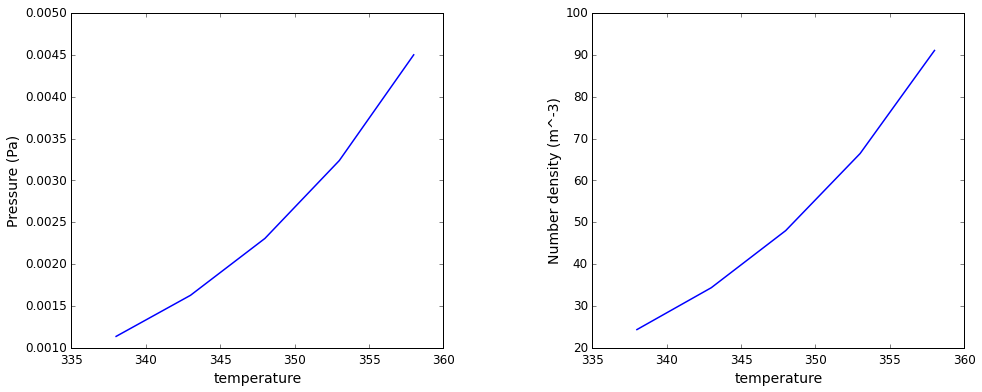

In [6]:
rcdef = plt.rcParams.copy()
newparams = {'axes.labelsize': 14, 'axes.linewidth': 1, 'savefig.dpi': 300, 
             'lines.linewidth': 1.5, 'figure.figsize': (16, 6),
             'figure.subplot.wspace': 0.4,
             'ytick.labelsize': 12, 'xtick.labelsize': 12,
             'ytick.major.pad': 5, 'xtick.major.pad': 5,
             'legend.fontsize': 12, 'legend.frameon': False, 
             'legend.handlelength': 1.5}

plt.rcParams.update(rcdef)
plt.rcParams.update(newparams)
fig, axes = plt.subplots(1, 2)

axes[0].plot(temp, P)
axes[1].plot(temp, number_density)

    
axes[0].set_xlabel('temperature')
axes[0].set_ylabel('Pressure (Pa)')
axes[1].set_xlabel('temperature')
axes[1].set_ylabel('Number density (m^-3)')
plt.rcParams.update(rcdef)

# Beer-Lambert Law

The intensity of light after passing a length $l$ is given by
$I=I_o e^{-\sigma n l}$
$\sigma$ is the cross-section of absorption (think of this as an effective area of a Rb atom). The 'bigger' the atom appears to light, the more likely the atom is to absorb light. We are not going to derive the cross-section here, we will just treat it as a property of Rb that we are interested in. It depends, among other things, on the wavelength of light. This is why we went to great lengths to isolate the D1 line. We will be taking this data as a function of number density, $n$. First let's plot our data to see what we are dealing with. This always a good first step in determining how we are going to fit.

In [9]:
#Our data
ABS=array([11,9.9,8.9,8.2,7.7]) #Absorbtion proxy, ie photodetector signal
s=array([0.002,0.01,0.02,0.02,0.01]) #uncertainty in voltage

<Container object of 3 artists>

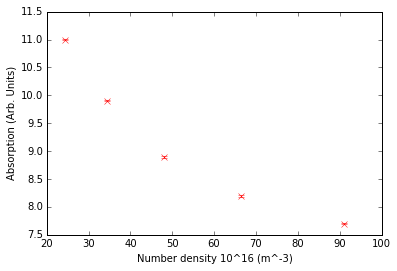

In [10]:
plt.xlabel('Number density 10^16 (m^-3)')
plt.ylabel('Absorption (Arb. Units)')
plt.errorbar(number_density, ABS, fmt = 'rx', yerr =s) #notice error bars are pretty small here.

As we can see from the plot below and our model of absorption (Beers' Law), the data might be well approximated by a decaying expoential. Another useful way of looking at non-linear data is to linearize it, so let's take the natural log of ABS

$\ln{I}=\ln{I_o}-\sigma n l$

In [11]:
logabs=log(ABS)
logs=array([0.000315507,0.001908397,0.004587156,0.003344482,0.003875969]) #scale error bars b/c we took ln
logabs

array([ 2.39789527,  2.29253476,  2.18605128,  2.10413415,  2.04122033])

<Container object of 3 artists>

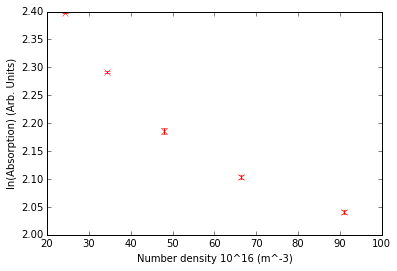

In [12]:
plt.xlabel('Number density 10^16 (m^-3)')
plt.ylabel('ln(Absorption) (Arb. Units)')
plt.errorbar(number_density, logabs, fmt = 'rx', yerr =logs) #notice error bars are pretty small here.

Our visual system is really quite good at seeing if data is linear, not so much other functions, and we can see above that that last point is going to be problematic. Let us persevere...

# Fitting

We are going to look at this from two perspectives. First, fitting with non-linearized data, then with the linear data. Both cases will require standard deviations to our data so we can make estimates on the fit parameter uncertainties and get an idea on the goodness of fit.

# Non-linear fit

First we are going to use our raw data and uncertainties. 

The first step in fitting to data is to define the fitting function. In this case a decaying exponential with three parameters $a$, an offset, $b$, the amplitude, and $c=\sigma\times N/V \times l$
The fitting routine will send different values of $a,b,c$ to func for a given value of N/V,
which will send back a value of func to compare to the actual data point. When the fitting routine has found a minimum it stops. This is not the most subtle of fitting algorithms and it is easy to get stuck in a false minimum of we use a poor choice of fitting parameters. We can take advantage of IPython's interactivity to try different solutions by hand.

In [13]:
#define the fitting function.
def func(x,a,b,c):
    return a+b*exp(-c*x)

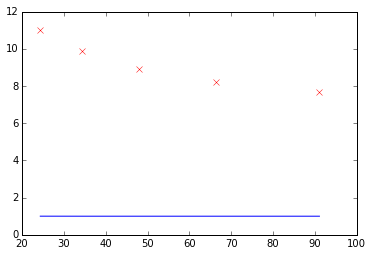

In [14]:
def fit_guess(a=1.,b=5,c=.11):
    plt.plot(number_density,func(number_density,a,b,c))
    plt.plot(number_density,ABS,'rx')
    
w=interactive(fit_guess,a=(-10.,50.,.1), b=(0,20.,.1), c=(0.01,2.,.01))
display(w)

When you find some values that get you fairly close, you can start the routine. Scipy uses the  Levenberg-Marquardt algorithm. For more info on the scipy implementation type help(optimization.curve_fit) into a blank cell. For more info on the algorithim go to http://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm. 

The advantage of doing fits this way and not doing them through Excel is that we can extract the uncertainties from covariance matrix which is returned with the solution by optimization.curve_fit.

The uncertainties that we are looking for are the square roots of the diagonal elements of the NxN covariance array (N is the number of fitting parameters). 

The other thing we want to do is to find out how good our fit is. We use the reduced Chi Square function:

$\chi^2=\sum_i(\frac{\textrm{fit}_i-\textrm{model}_i)}{\sigma_i})^2$

The reduced $\chi^2$ function ($\chi^2_\nu$) is just $\chi^2$ divided by the number of degrees of freedom. The degrees of freedom is just the number of data points used in the fit divided by the number of fitting parameters. What does $\chi^2$ and $\chi^2_\nu$ tell us? Looking at $\chi^2$ we see that each term in the sum is telling us how far the model and the data are from each other relative to the uncertainty. A good fit should have the fit value within the error bars of that data point. If this is true we expect each term to be less than one. However, if each term is much les than one, then we have probably overestimated our error bars, which means our fit isn't well constrained. With larger error bars a wide number of fit parameters will do the trick and we should rethink things. If each term is too large, then we may have a bad model or we have too small of uncertainties. By dividing $\chi^2$ by the degrees of freedom we get an "average" distance, which should be around one. The GOF calculation tells us what the probability of obtaining a higher $\chi^2$ should we do the fit again with new data.

/Users/schultzk/anaconda/envs/Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


a= 7.378401 +/- 0.024793
b= 7.378401 +/- 0.090610
c= 7.378401 +/- 0.000646


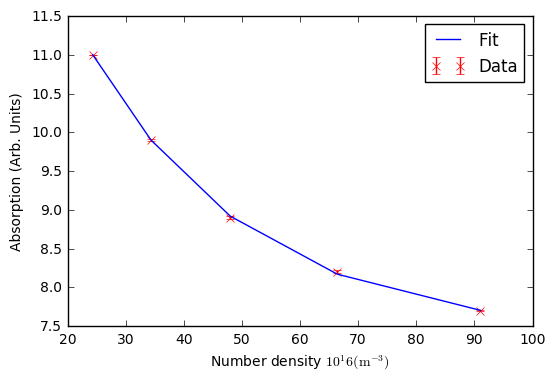

Reduced Chi Square=0.024194
Probability to obtain a higher Chi Square=0.976097


In [33]:
x0=array([8,6.8,0.8]) #Enter your intial guess here x0={a,b,c}
#calls the solver and puts the solution into the array solution, the uncertainties are put into the
#array covar. 
solution,covar= optimization.curve_fit(func,number_density,ABS,x0,s)
#Fit parameters and uncertainties
print("a= %f +/- %f" % (solution[0],sqrt(covar[0,0])))
print("b= %f +/- %f" % (solution[0],sqrt(covar[1,1])))
print("c= %f +/- %f" % (solution[0],sqrt(covar[2,2])))

plt.xlabel(r'Number density $10^16 (\mathrm{m}^{-3})$')
plt.ylabel('Absorption (Arb. Units)')
plt.errorbar(number_density, ABS, fmt = 'rx', yerr =s,label='Data') 
plt.plot(number_density,func(number_density,solution[0],solution[1],solution[2]),label='Fit')
plt.legend(loc='upper right')
plt.show()
#Calculate Goodness of fit.
chisqr=numpy.sum((ABS-func(number_density,solution[0],solution[1],solution[2]))/s)**2
dof=len(ABS)-len(x0)
GOF = 1. - chi2.cdf(chisqr,dof)
print("Reduced Chi Square=%f" %(chisqr/dof))
print("Probability to obtain a higher Chi Square=%f"%(GOF))
fig = plt.gcf()
#py.iplot_mpl(fig)


#Uncomment the next line to export graph to a file. As the line below stands, the file will be
#placed in the same directory as the notebook file.

#plt.savefig("blah.pdf")

OK. Looking at the numbers we have, this an acceptable goodness of fit and I feel pretty confident about what I am seeing. Another useful tool is to plot the residuals, i.e. the straight difference between the fit and data, and make sure that they are equally above and below zero. If at some point you see that there are more points above or below zero that is a good indication your fit isn't quite right.

Now for what we really want (It is easy to lose sight of where we need to be with data analysis!), the cross-section! So rescale our solution and divide by the length of the cell, in this case 2.5 cm. Since we are taking a number with an uncertainty, we need to change the uncertainty as well.

In [37]:
crosssection=solution[2]/1e16/0.025
sigma_cross=(sqrt(covar[2,2])/1e16/0.025)
print("cross section= %e +/- %e" % (crosssection,sigma_cross))

#Remember that you got to watch your significant figures when actually reporting your results.
#Our data do not justify such high precision as we see below

cross section= 1.445754e-16 +/- 2.585420e-18


## Fitting to a Linearized Dataset

As we mentioned above, sometimes linearizing our data makes it easier to understand and check. Often times you might have better luck running the fit algorithms when the data has been linearized, so for completeness here is how we do that.

In [38]:
def func2(x, a, b):
    return a+b*x #Our linear function.

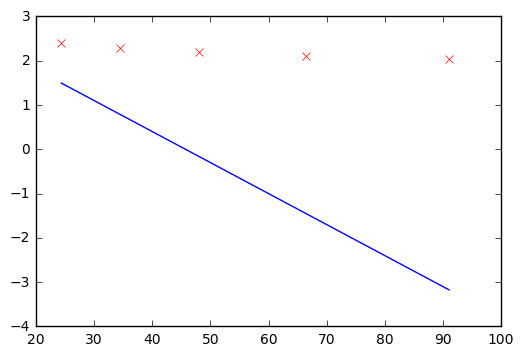

In [39]:
def fit_guess(a=1.,b=-.11):
    plt.plot(number_density,func2(number_density,a,b))
    plt.plot(number_density,logabs,'rx')
    
w=interactive(fit_guess,a=(-10.,10,0.1), b=(-5,5,0.01))
display(w)

a= 2.549964 +/- 0.021726 
b= -0.006296 +/- 0.000823 


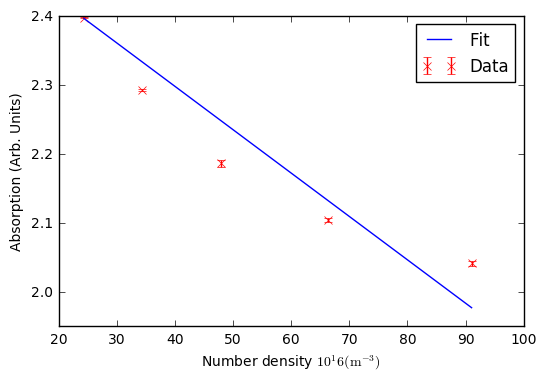

Reduced Chi Square=0.759420
Probability to obtain a higher Chi Square=0.516698


In [44]:
logx0=array([1.3,-.005]) #Intial guess

#calls the solver and puts the solution into the array solution, the uncertainties are put into the
#array covar. 
solution,covar= optimization.curve_fit(func2, number_density, logabs, logx0, logs)
#Fit parameters and uncertainties
print("a= %f +/- %f " % (solution[0],sqrt(covar[0,0])))
print ("b= %f +/- %f " % (solution[1],sqrt(covar[1,1])))

plt.xlabel(r'Number density $10^16 (\mathrm{m}^{-3})$')
plt.ylabel('Absorption (Arb. Units)')
plt.errorbar(number_density, logabs, fmt = 'rx', yerr =logs,label='Data') 
plt.plot(number_density,func2(number_density,solution[0],solution[1]),label='Fit')
plt.legend(loc='upper right')
plt.show()
chisqr=numpy.sum((logabs-func2(number_density,solution[0],solution[1]))/s)**2
dof=len(logabs)-len(logx0)
GOF = 1. - chi2.cdf(chisqr,dof)
print("Reduced Chi Square=%f"%(chisqr/dof))
print("Probability to obtain a higher Chi Square=%f"%(GOF))
#Uncomment the next line to export graph to a file. As the line below stands, the file will be
#placed in the same directory as the notebook file.

#plt.savefig("data.pdf")

In [41]:
crosssection=-solution[1]/1e16/0.025
sigma_cross=(sqrt(covar[1,1])/1e16/0.025)
print("cross section= %e +/- %e" %(crosssection,sigma_cross))

cross section= -3.492808e-14 +/- 3.624415e-16


Everything is a little different here. Why? I don't know. My suspicion is that last data point. If I were turning this in for a report or as the results of a paper, I would make sure my results were more consistent. 